In [6]:
# Step 1: Import libraries and load cleaned dataset

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StrastifiedKFold, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (classification_report, confusion_matrix,
                             roc_auc_score, average_precision_score,
                             precision_recall_curve, roc_curve)

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

from pathlib import Path

# Load the cleaned datasetfrom imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.ensemble import RandomForestClassifier

rf_clf = ImbPipeline(steps=[
    ('preprocess', preprocess),
    ('smote', SMOTE(random_state=42)),   # <-- resamples minority class only in training folds
    ('model', RandomForestClassifier(
        n_estimators=400,
        random_state=42,
        n_jobs=-1
    ))
])

DATA_PATH = Path("../data/stroke_clean.csv")  # adjust if path differs
df = pd.read_csv(DATA_PATH)

print(df.shape)
df.head()
# df.tail()


(5110, 12)


,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,male,67.0,0,1,yes,private,urban,228.69,36.6,formerly smoked,1
1,51676,female,61.0,0,0,yes,self-employed,rural,202.21,28.1,never smoked,1
2,31112,male,80.0,0,1,yes,private,rural,105.92,32.5,never smoked,1
3,60182,female,49.0,0,0,yes,private,urban,171.23,34.4,smokes,1
4,1665,female,79.0,1,0,yes,self-employed,rural,174.12,24.0,never smoked,1


In [11]:
# Step 2: Define features and target

target = 'stroke'

feature_columns = [
    'gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
    'work_type', 'Residence_type', 'avg_glucose_level', 'bmi', 'smoking_status'
]

X = df[feature_columns].copy()
y = df[target].astype(int)

# Stratified split to preserve class ratio
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print("Train shape:", X_train.shape, " Test shape:", X_test.shape)
print("Stroke ratio (train):", y_train.value_counts(normalize=True))


Train shape: (4088, 10)  Test shape: (1022, 10)
Stroke ratio (train): stroke
0    0.951321
1    0.048679
Name: proportion, dtype: float64


In [4]:
# Step 3: Build preprocessing pipeline

numeric_features = ['age', 'avg_glucose_level', 'bmi']
categorical_features = [
    'gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status'
]

num_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

cat_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

preprocess = ColumnTransformer(
    transformers=[
        ('num', num_pipeline, numeric_features),
        ('cat', cat_pipeline, categorical_features)
    ]
)


In [13]:
# Step 4 - Addressing Class Imbalance - increase the penalty for misclassification in logistic regression
# - We keep the original data intact and therefore no artificial sampling
# 3 training techgniques as proposed with respect to Data Imbalance we have: 
# - Class Weighting for Logistic Regression, SMOTE technique,XGBoosting 

In [8]:
# 4.1 Logistic Regression with class weighting
logit_clf = Pipeline(steps=[
    ('preprocess', preprocess),
    ('model', LogisticRegression(
        max_iter=2000,
        class_weight='balanced',   # <-- handles imbalance internally
        solver='liblinear'
    ))
])
# model was trained using built-in class weighting to offset the 5 % stroke prevalence. 
# This method ensures the minority class contributes proportionally to the loss function without resampling the data.

In [15]:
# 4.2 SMOTE Oversampling (for Random Forest or other non-weighted models)
# Random Forest classifier was trained within an imbalanced-learning pipeline that applied Synthetic Minority Oversampling Technique (SMOTE) to the training folds, - Preventing data leakage 
# Ensures balanced representation of stroke and non-stroke cases during training.
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.ensemble import RandomForestClassifier

rf_clf = ImbPipeline(steps=[
    ('preprocess', preprocess),
    ('smote', SMOTE(random_state=42)),   # <-- resamples minority class only in training folds
    ('model', RandomForestClassifier(
        n_estimators=400,
        random_state=42,
        n_jobs=-1
    ))
])


In [16]:
# 4.3 Scale Pos Weight (for XGBoost)
# - tells the booster to weight positive examples more.
# XGBoost is sensitive to class imbalance but supports this natively.
# the class imbalance was addressed through the scale_pos_weight parameter, calculated as the ratio of negative to positive samples in the training set. 
# This ensures the boosting algorithm penalizes missed stroke cases more heavily.

from xgboost import XGBClassifier

# compute weight ratio
pos = (y_train == 1).sum()
neg = (y_train == 0).sum()
scale_pos_weight = neg / pos

xgb_clf = Pipeline(steps=[
    ('preprocess', preprocess),
    ('model', XGBClassifier(
        n_estimators=400,
        learning_rate=0.05,
        max_depth=4,
        subsample=0.9,
        colsample_bytree=0.9,
        random_state=42,
        eval_metric='logloss',
        scale_pos_weight=scale_pos_weight   # <-- imbalance compensation
    ))
])



=== Logistic (balanced) @ threshold=0.50 ===
              precision    recall  f1-score   support

           0      0.986     0.743     0.847       972
           1      0.138     0.800     0.235        50

    accuracy                          0.746      1022
   macro avg      0.562     0.771     0.541      1022
weighted avg      0.945     0.746     0.817      1022



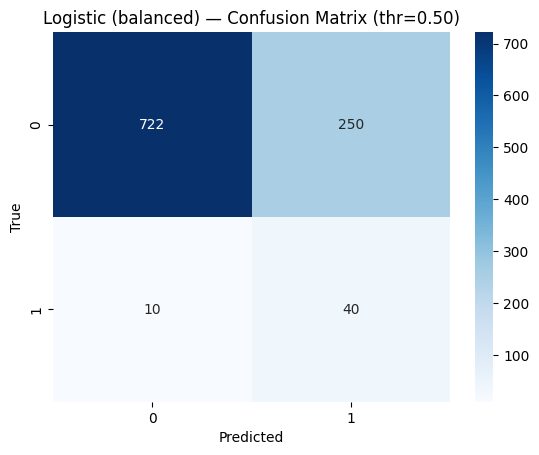


=== Logistic (balanced) @ threshold=0.73 ===
              precision    recall  f1-score   support

           0      0.983     0.873     0.925       972
           1      0.222     0.700     0.337        50

    accuracy                          0.865      1022
   macro avg      0.602     0.787     0.631      1022
weighted avg      0.945     0.865     0.896      1022



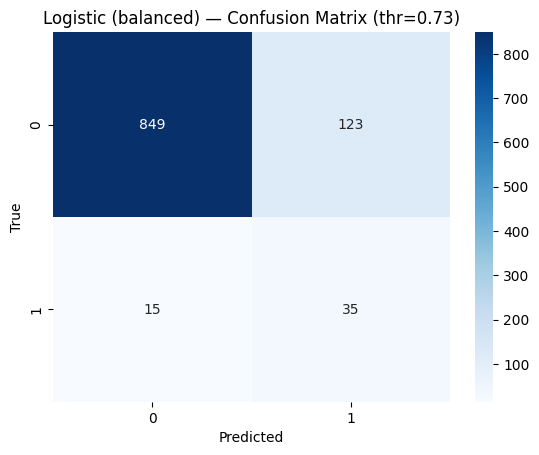


=== RandomForest + SMOTE @ threshold=0.50 ===
              precision    recall  f1-score   support

           0      0.955     0.967     0.961       972
           1      0.158     0.120     0.136        50

    accuracy                          0.926      1022
   macro avg      0.557     0.544     0.549      1022
weighted avg      0.916     0.926     0.921      1022



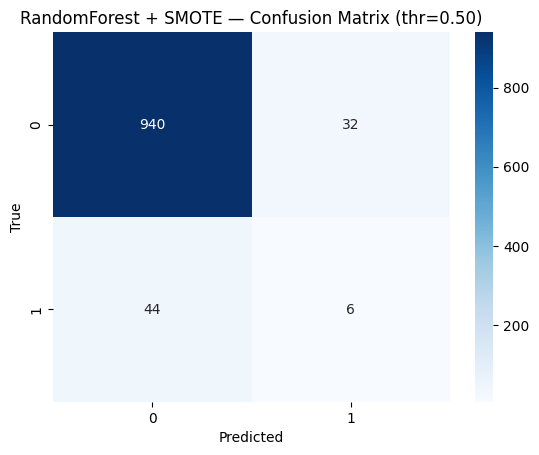


=== RandomForest + SMOTE @ threshold=0.09 ===
              precision    recall  f1-score   support

           0      0.985     0.698     0.817       972
           1      0.120     0.800     0.208        50

    accuracy                          0.703      1022
   macro avg      0.553     0.749     0.513      1022
weighted avg      0.943     0.703     0.787      1022



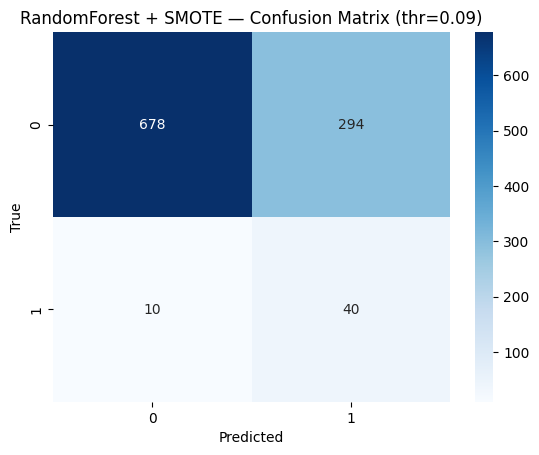


=== XGBoost (SPW) @ threshold=0.50 ===
              precision    recall  f1-score   support

           0      0.968     0.915     0.941       972
           1      0.202     0.420     0.273        50

    accuracy                          0.890      1022
   macro avg      0.585     0.667     0.607      1022
weighted avg      0.931     0.890     0.908      1022



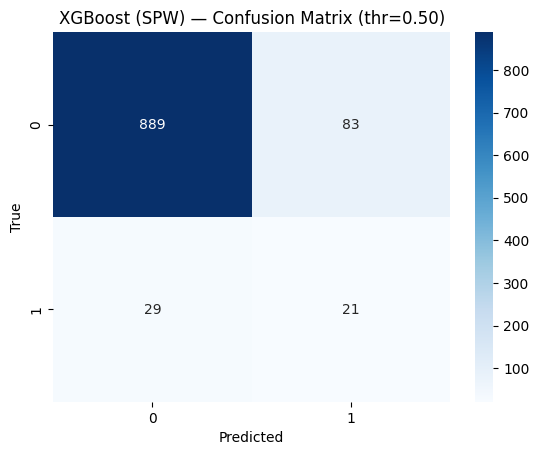


=== XGBoost (SPW) @ threshold=0.35 ===
              precision    recall  f1-score   support

           0      0.975     0.871     0.920       972
           1      0.183     0.560     0.276        50

    accuracy                          0.856      1022
   macro avg      0.579     0.716     0.598      1022
weighted avg      0.936     0.856     0.889      1022



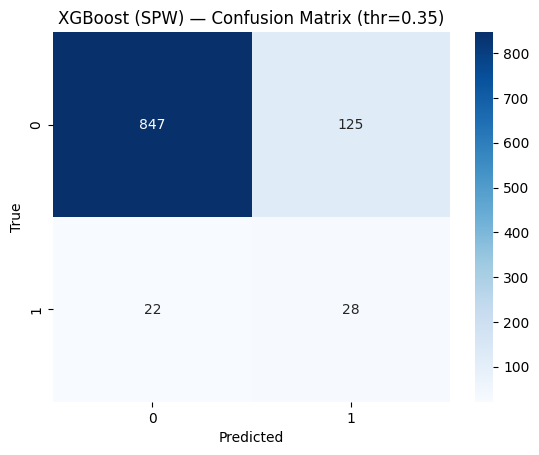

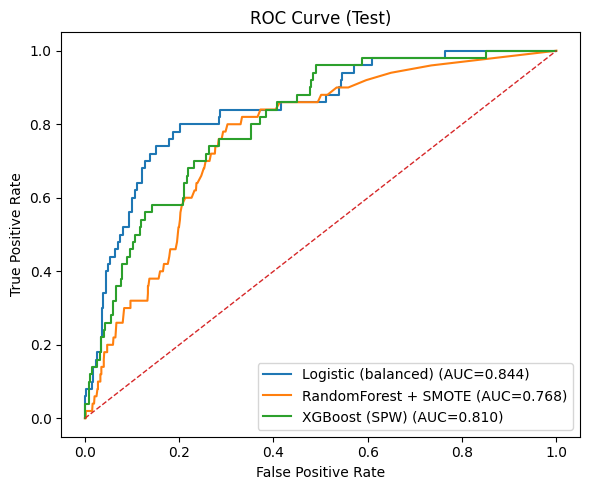

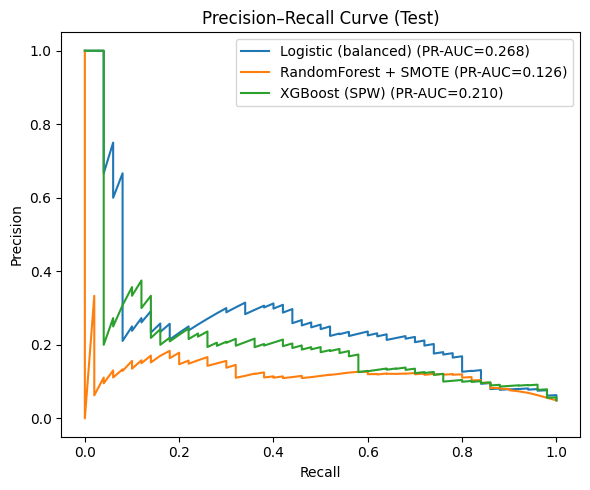


Saved metrics to: reports/model_metrics.csv


In [19]:
# STEP 5: Train, handle imbalance, evaluate, and compare three models
# Models: Logistic Regression (class_weight), RandomForest (+SMOTE), XGBoost (scale_pos_weight)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (classification_report, confusion_matrix,
                             roc_auc_score, average_precision_score,
                             precision_recall_curve, roc_curve, f1_score)

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

# If xgboost isn't installed, run: pip install xgboost
from xgboost import XGBClassifier

# ---------- Load cleaned data ----------
DATA_PATH = Path("../data/stroke_clean.csv")  # adjust if different
df = pd.read_csv(DATA_PATH)

target = "stroke"
feature_columns = [
    "gender","age","hypertension","heart_disease","ever_married",
    "work_type","Residence_type","avg_glucose_level","bmi","smoking_status"
]
X = df[feature_columns].copy()
y = df[target].astype(int).copy()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=42
)

# ---------- Preprocessing (leak-proof) ----------
numeric_features = ["age","avg_glucose_level","bmi"]
categorical_features = list(set(feature_columns) - set(numeric_features))

num_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])
cat_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])
preprocess = ColumnTransformer([
    ("num", num_pipeline, numeric_features),
    ("cat", cat_pipeline, categorical_features),
])

# ---------- Class imbalance helpers ----------
pos = int((y_train == 1).sum())
neg = int((y_train == 0).sum())
scale_pos_weight = neg / max(pos, 1)  # for XGB

# ---------- Define three models ----------
models = {
    "Logistic (balanced)": Pipeline([
        ("pre", preprocess),
        ("clf", LogisticRegression(max_iter=2000, class_weight="balanced", solver="liblinear"))
    ]),
    "RandomForest + SMOTE": ImbPipeline([
        ("pre", preprocess),
        ("smote", SMOTE(random_state=42)),
        ("clf", RandomForestClassifier(n_estimators=400, random_state=42, n_jobs=-1))
    ]),
    "XGBoost (SPW)": Pipeline([
        ("pre", preprocess),
        ("clf", XGBClassifier(
            n_estimators=500,
            max_depth=4,
            learning_rate=0.05,
            subsample=0.9,
            colsample_bytree=0.9,
            random_state=42,
            eval_metric="logloss",
            scale_pos_weight=scale_pos_weight,
            n_jobs=-1
        ))
    ])
}

# ---------- Metric helpers ----------
def pr_auc(y_true, y_prob):
    return average_precision_score(y_true, y_prob)

def best_threshold_for_fbeta(y_true, y_prob, beta=2.0):
    """Return threshold that maximizes F-beta (default F2: recall-weighted)."""
    precisions, recalls, thresholds = precision_recall_curve(y_true, y_prob)
    thresholds = np.append(thresholds, 1.0)  # align lengths
    beta2 = beta**2
    fbeta = (1+beta2) * (precisions*recalls) / (beta2*precisions + recalls + 1e-12)
    idx = np.nanargmax(fbeta)
    return float(thresholds[idx]), float(fbeta[idx]), float(precisions[idx]), float(recalls[idx])

def print_eval(y_true, y_prob, model_name, threshold=0.5):
    y_pred = (y_prob >= threshold).astype(int)
    print(f"\n=== {model_name} @ threshold={threshold:.2f} ===")
    print(classification_report(y_true, y_pred, digits=3))
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"{model_name} — Confusion Matrix (thr={threshold:.2f})")
    plt.xlabel("Predicted"); plt.ylabel("True")
    plt.show()

# ---------- Train, evaluate, compare ----------
metrics_rows = []
roc_curves = []
pr_curves = []

for name, pipe in models.items():
    # cross-val ROC-AUC on train (threshold-free)
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    cv_auc = cross_val_score(pipe, X_train, y_train, cv=cv, scoring="roc_auc").mean()

    # fit and predict proba
    pipe.fit(X_train, y_train)
    y_prob = pipe.predict_proba(X_test)[:, 1]

    # threshold-free metrics on test
    roc = roc_auc_score(y_test, y_prob)
    pr = pr_auc(y_test, y_prob)

    # pick recall-favoring threshold by maximizing F2
    thr_star, f2_star, p_star, r_star = best_threshold_for_fbeta(y_test, y_prob, beta=2.0)

    # store metrics
    metrics_rows.append({
        "model": name,
        "cv_roc_auc_train": round(cv_auc, 4),
        "roc_auc_test": round(roc, 4),
        "pr_auc_test": round(pr, 4),
        "best_thr_F2": round(thr_star, 3),
        "F2_at_best_thr": round(f2_star, 4),
        "precision_at_best_thr": round(p_star, 4),
        "recall_at_best_thr": round(r_star, 4),
    })

    # plot reports at default and tuned thresholds
    print_eval(y_test, y_prob, name, threshold=0.50)
    print_eval(y_test, y_prob, name, threshold=thr_star)

    # cache curves for combined plots
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    prec, rec, _ = precision_recall_curve(y_test, y_prob)
    roc_curves.append((name, fpr, tpr, roc))
    pr_curves.append((name, rec, prec, pr))

# ---------- Metrics table ----------
metrics_df = pd.DataFrame(metrics_rows).sort_values(by="pr_auc_test", ascending=False)
metrics_df
Path("reports").mkdir(parents=True, exist_ok=True)
metrics_df.to_csv("reports/model_metrics.csv", index=False)

# ---------- Combined ROC plot ----------
plt.figure(figsize=(6,5))
for name, fpr, tpr, roc in roc_curves:
    plt.plot(fpr, tpr, label=f"{name} (AUC={roc:.3f})")
plt.plot([0,1],[0,1],'--',linewidth=1)
plt.title("ROC Curve (Test)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.tight_layout()
plt.show()

# ---------- Combined PR plot ----------
plt.figure(figsize=(6,5))
for name, rec, prec, pr in pr_curves:
    plt.plot(rec, prec, label=f"{name} (PR-AUC={pr:.3f})")
plt.title("Precision–Recall Curve (Test)")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()
plt.tight_layout()
plt.show()

print("\nSaved metrics to: reports/model_metrics.csv")
